In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
import os
import numpy as np

style.use("ggplot")

from sys import path
path.append("../utils/")

from pnl500_lister import save_sp500_tickers
from utils import get_data_from_yahoo

#enable for interactive plots in jupyter NOTEBOOKS
#%matplotlib notebook

/home/wabo/anaconda2/envs/datajungle/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Params

In [2]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2016, 12, 31)

## Import Data

In [3]:
df = web.DataReader('TSLA', 'yahoo', start, end)

print(df.head())

             High        Low       Open      Close    Volume  Adj Close
Date                                                                   
2010-06-29  25.00  17.540001  19.000000  23.889999  18766300  23.889999
2010-06-30  30.42  23.299999  25.790001  23.830000  17187100  23.830000
2010-07-01  25.92  20.270000  25.000000  21.959999   8218800  21.959999
2010-07-02  23.10  18.709999  23.000000  19.200001   5139800  19.200001
2010-07-06  20.00  15.830000  20.000000  16.110001   6866900  16.110001


## Plots

### Plot some interesting columns over time

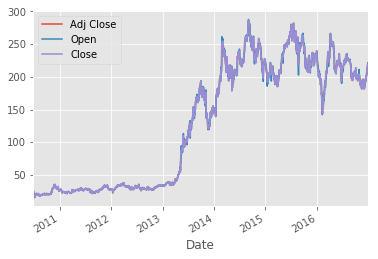

In [4]:
interesting_columns = ['Adj Close', 'Open', 'Close']

df[interesting_columns].plot()
plt.show()

## Adding new columns

In [5]:
#100-day moving average
df["100ma"] = df['Adj Close'].rolling(window = 100, min_periods = 0).mean()

print(df.head())

             High        Low       Open      Close    Volume  Adj Close  \
Date                                                                      
2010-06-29  25.00  17.540001  19.000000  23.889999  18766300  23.889999   
2010-06-30  30.42  23.299999  25.790001  23.830000  17187100  23.830000   
2010-07-01  25.92  20.270000  25.000000  21.959999   8218800  21.959999   
2010-07-02  23.10  18.709999  23.000000  19.200001   5139800  19.200001   
2010-07-06  20.00  15.830000  20.000000  16.110001   6866900  16.110001   

                100ma  
Date                   
2010-06-29  23.889999  
2010-06-30  23.860000  
2010-07-01  23.226666  
2010-07-02  22.220000  
2010-07-06  20.998000  


### Plot 100ma

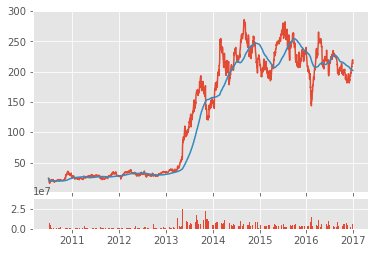

In [6]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])

ax2.bar(df.index, df['Volume'])

plt.show()

## Data Resampling

In [7]:
#Open-High-Low-Close over 10 days
df_ohlc = df['Adj Close'].resample('10D').ohlc()
#reset index to convert it to mdate
df_ohlc.reset_index(inplace=True)
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)


#Volume
df_volume = df['Volume'].resample('10D').sum()

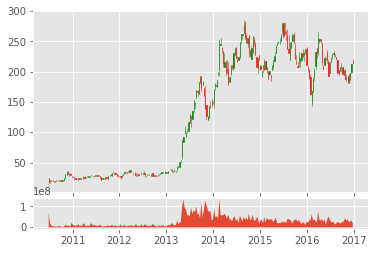

In [8]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

ax1.xaxis_date()
candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')

#fill from 0 to the y-value
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)

plt.show()

## Get list of P&L 500 and save data locally

In [14]:
tickers = save_sp500_tickers("../utils/")
#get the first ten
tickers = tickers[:10]

get_data_from_yahoo(tickers, start, end, "../local_data/")

Already have MMM
Already have ABT
Already have ABBV
Already have ABMD
Already have ACN
Already have ATVI
Already have ADBE
Already have AMD
Already have AAP
Already have AES


## Compile data

In [7]:
main_df = pd.DataFrame()
data_dir = "../local_data/stock_dfs/"

for count, ticker in enumerate(tickers):
    df = pd.read_csv(data_dir + "{}.csv".format(ticker))
    df.set_index('Date', inplace=True)
    
    df.rename(columns = {'Adj Close': ticker}, inplace=True)
    #drop unneeded columns
    df.drop(['Open', 'Close', 'Low', 'Close', 'Volume', 'High'], axis=1, inplace=True)
    
    if main_df.empty:
        main_df = df
    else:
        main_df = main_df.join(df, how='outer')
        
    if count % 10 == 0:
        print("Progress: ", count)

Progress:  0
                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  27.481184  6.730005   NaN  18.25000  NaN  1.245554  16.145748   
2000-01-04  26.389219  6.537722   NaN  17.81250  NaN  1.207666  14.791295   
2000-01-05  27.153585  6.525703   NaN  18.00000  NaN  1.212402  15.083735   
2000-01-06  29.337526  6.754039   NaN  18.03125  NaN  1.188722  15.206868   
2000-01-07  29.919918  6.826150   NaN  17.93750  NaN  1.221874  15.945663   

               AMD  AAP        AES  
Date                                
2000-01-03  15.500  NaN  29.731331  
2000-01-04  14.625  NaN  28.552334  
2000-01-05  15.000  NaN  28.859903  
2000-01-06  16.000  NaN  29.090569  
2000-01-07  16.250  NaN  29.654444  


In [11]:
print(main_df.head())
print(main_df.tail())

#save df_main
main_df.to_csv('../local_data/sp500_joined_closes.csv')

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  27.481184  6.730005   NaN  18.25000  NaN  1.245554  16.145748   
2000-01-04  26.389219  6.537722   NaN  17.81250  NaN  1.207666  14.791295   
2000-01-05  27.153585  6.525703   NaN  18.00000  NaN  1.212402  15.083735   
2000-01-06  29.337526  6.754039   NaN  18.03125  NaN  1.188722  15.206868   
2000-01-07  29.919918  6.826150   NaN  17.93750  NaN  1.221874  15.945663   

               AMD  AAP        AES  
Date                                
2000-01-03  15.500  NaN  29.731331  
2000-01-04  14.625  NaN  28.552334  
2000-01-05  15.000  NaN  28.859903  
2000-01-06  16.000  NaN  29.090569  
2000-01-07  16.250  NaN  29.654444  
                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2016-12-23  170.135162  36.873093  57.887970  112.379997 

## Company Correlation Table

In [15]:
options = ["plot", "corr"]

def visualize_data(option="plot", ticker="", verbose=False):
    df = pd.read_csv('../local_data/sp500_joined_closes.csv')
    if option=="plot":
        print(df[ticker].head())
        df[ticker].plot()
        plt.show()
        
    elif option=="corr":
        df_corr = df.corr()
        if verbose:
            print(df_corr.head())
    
        data = df_corr.values
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
        fig.colorbar(heatmap)
        ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor = False)
        ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor = False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        
        column_labels = df_corr.columns
        row_labels = df_corr.index
        
        ax.set_xticklabels(column_labels)
        ax.set_yticklabels(row_labels)
        
        plt.xticks(rotation=90)
        #the scale we need. correlation is ja between -1, 1
        heatmap.set_clim(-1,1)
        
        plt.tight_layout()
        plt.show()
        
        return df

           MMM       ABT      ABBV      ABMD       ACN      ATVI      ADBE  \
MMM   1.000000  0.948626  0.917590  0.793535  0.966675  0.926923  0.930757   
ABT   0.948626  1.000000  0.870608  0.722083  0.960316  0.889726  0.878065   
ABBV  0.917590  0.870608  1.000000  0.758086  0.782810  0.740370  0.868343   
ABMD  0.793535  0.722083  0.758086  1.000000  0.860758  0.864955  0.872125   
ACN   0.966675  0.960316  0.782810  0.860758  1.000000  0.939226  0.924783   

           AMD       AAP       AES  
MMM  -0.521923  0.967229 -0.290799  
ABT  -0.601495  0.958861 -0.247201  
ABBV  0.188658  0.896813  0.056811  
ABMD -0.247162  0.844651  0.022127  
ACN  -0.511405  0.963566  0.040392  


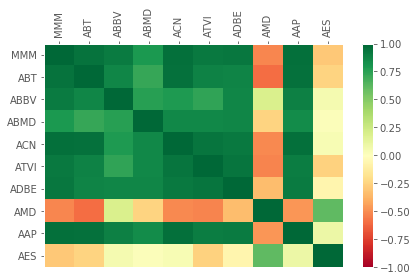

In [16]:
df = visualize_data(option="corr", verbose=True)

0    1.245554
1    1.207666
2    1.212402
3    1.188722
4    1.221874
Name: ATVI, dtype: float64


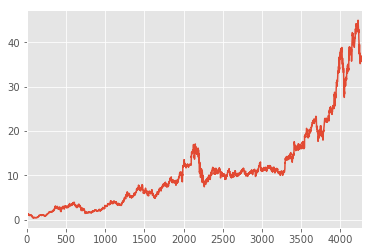

In [17]:
ticker = tickers[5]
visualize_data(option="plot", ticker=ticker, verbose=True)

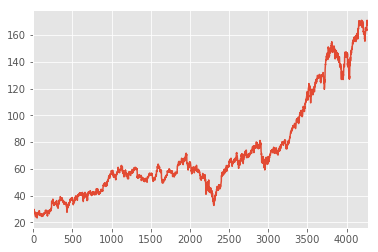

In [64]:
df['MMM'].plot()
plt.show()